# Canceling and Selecting Partials from Musical Tones Using Fractional-Delay Filters

Heidi-Maria Lehtonen, Vesa Välimäki and Timo I. Laakso

- Write a compact summary (approx. 2-3 pages) and your own thoughts
- Implement and explore some algorithm presented in the paper using Matlab
- Report your findings

The paper claims that one can use fractional-delay filters to cancel and select partials from musical signals. Such filters are variations of inverse transfer function of a comb filter. The idea of canceling harmonics from a musical signal using digital filters was first introduced by Moorer in 1974, where Moorer published papers about pitch detection and analyzing music data for additive synthesis. 

This paper is an extended study of Välimäki et al. which claimed that **the delay line in the inverse comb filter(ICF) can be replaced with a high-order fractional-delay filter** to obtain very accurate cancellation of neighboring harmonics to select a single harmonic or to extract the residual signal by canceling all harmonics.

Compared to general FFT-based techniques(McAulay and Quatieri 1986; Serra 1989; Serra and Smith 1990), which is a popular tool for signal decomposition, fractional-delay filters have smaller number of parameters, and one can design filter coefficients in closed form. The decomposition results in time-domain directly thus, no separate transformation is required.

There have been multiple efforts on analyzing the harmonic structure of musical signals; wavelets(Evangelista 1993) and high resolution tracking methods(Badeau, David, and Richard 2006). While these methods deliver very high frequency estimation accuracy, they are computationally expensive.  Fractional-delay filters estimate both frequency and amplitude with high accuracy, low cost and easy to use.





## Inverse Comb Filter(ICF)

The inverse comb filter(ICF) is an FIR filter in which input signal is delayed by $L$ samples and is then subtracted  from the original input signal.

$$
H_{\mathrm{ICF}}(z)=\left(1-\mathrm{z}^{-L}\right) / 2
$$

![icf_block_diagram](images/icf_block_diagram.png)

The magnitude response of this filter features periodic notches at the multiples of $f_{\mathrm{s}} / L$, where $f_{\mathrm{s}}$  is the sampling rate(Hz) and $L$ is the delay line length in samples.

## FIR Fractional-Delay Filter Design

For simplicity, we assume that the length of the delay element $L_1 = L_2 = 0$, no additional delay is present in either branch.

$$
H(z)=\frac{1}{2}\left[1-H_{\mathrm{fd}}(z)\right]
$$

![fd_filter_block_diagram](images/fd_filter_block_diagram.png)


where the $N$th-order transfer function $H_{\text{fd}}(z)$ can be expressed as 

$$
H_{\mathrm{fd}}(z)=\sum_{n=0}^{N} h(n) z^{-n}
$$

## Why Fractional-Delay Filter?

Most often harmonics we target to cancel do not have periods that are integers, hence we need a *fractional-delay* filter for fractional periods.

----------------
## Code 

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18   # Time and Hz, i.e. labels
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18  # Time(x) tick values
plt.rcParams['ytick.labelsize'] = 18  # Hz(y) tick values
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 20   # Title font

from scipy.signal import freqz, lfilter

from asp import config
import numpy as np
from asp.core import read_wave, Wave
from IPython.display import Audio, display
from scipy.io import wavfile
from asp.core import thinkdsp, thinkplot

We can break the process of harmonic cancelation in two steps: Inverse Comb Filter and $N$th-order transfer function.

### Fractional-delay filter based Inverse Comb Filter

$$
H(z)=\frac{1}{2} [1-H_{\mathrm{fd}}(z)]
$$

### $N$th-order transfer function

$$
H_{\mathrm{fd}}(z)=\sum_{n=0}^{N} h(n) Z^{-n}
$$
where $h(n)$ is,

$$h(n)=\prod_{k=0 \atop k \neq n}^{N} \frac{D-k}{n-k} \quad \text{for $n = 0,1,2,\ldots,N$} $$

- $D$: Delay in samples of F0 to be removed
- $N$: Filter order


Text(0.5, 1.0, 'Numerator coeff. of Fractinal Delay Transfer function. D = 300.343')

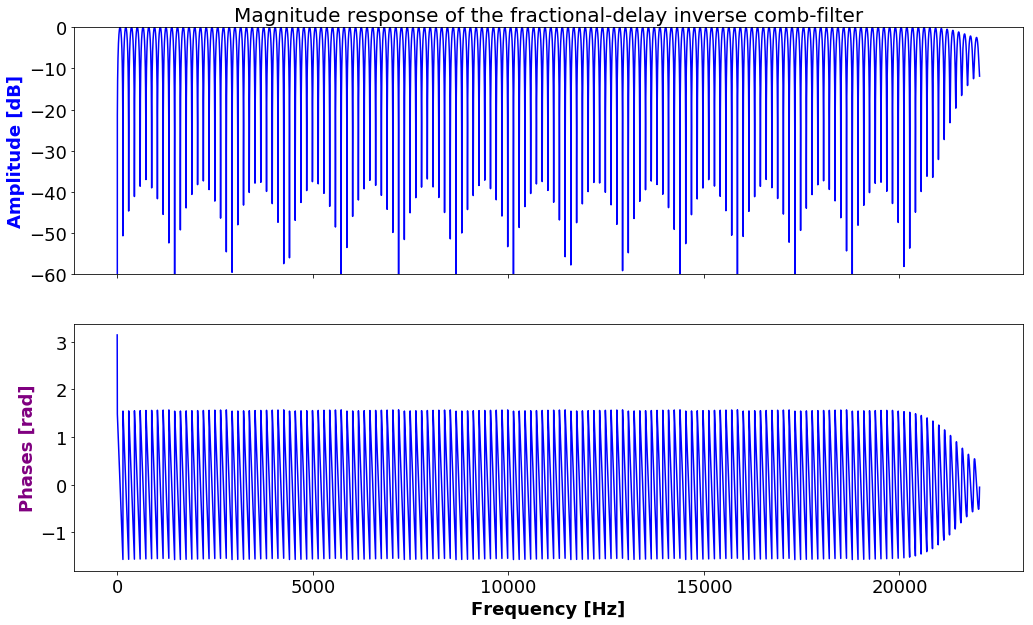

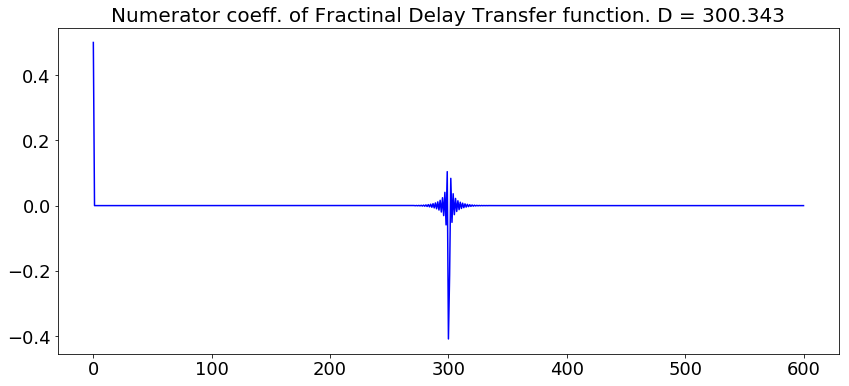

In [3]:
def n_th_order_transfer_function(D, N=160):
    """
    Args:
        D = 174.3   # Frequency to remove
        N = 160     # Chunk size
    """
    h = np.zeros(N+1)
    for n in range(N+1):                                               
        """Calculate largrange interpolation in vectorized form"""
        ks = np.arange(N+1)
        
        # Skip the k = n in order to avoid zero division error
        h[n] = np.prod( (D-ks[:n])/(n-ks[:n]) ) \
             * np.prod( (D-ks[n+1:])/(n-ks[n+1:]) ) 
        
    return h


def fractional_delay(f0, fs=44100):
    #-------------------------------------------------
    # Get Lagrange interpolation
    D = fs / f0
    
    '''
    NOTE: The original paper notes, `N = 160`. However, 
    that value did not work for us and we just landed on random 
    value by trial and error.
    '''
    N = int(2*D)   
    
    # Numerators/Coefficients of FIR filter
    b_L = n_th_order_transfer_function(D=D, N=N)
    
    # Numerators of delay
    b_delay = np.zeros_like(b_L)
    b_delay[0] = 1
    
    # This is the final numerator of the transfer function
    b = 1/2 * (b_delay - b_L)   

    nfft = 2**14
    #-------------------------------------------------
    # Output of freqz()
    # w : ndarray
    #     The frequencies at which `h` was computed, in the same units as `fs`.
    #     By default, `w` is normalized to the range [0, pi) (radians/sample).
    # h : ndarray
    #     The frequency response, as complex numbers.
    w, H = freqz(b=b, worN=nfft, whole=False)
        
    H_dB = 20 * np.log10(abs(H)) # abs() converts a complex number to a real number.
    
    w *= 0.5 * fs / np.pi        # Renormalize `w` to Nyquist sample rate
    
    return b, w, H_dB, np.angle(H)
f0=146.832
b, w, H, phases = fractional_delay(f0) 
f, axarr = plt.subplots(2, sharex=True, figsize=(17, 10))
# Plot magnitude
axarr[0].plot(w, H, 'blue')
axarr[0].set_ylabel('Amplitude [dB]', color='blue')
axarr[0].set_ylim([-60,0])
axarr[0].set_title('Magnitude response of the fractional-delay inverse comb-filter')
# Plot angles/phases
axarr[1].plot(w, phases, 'blue')
axarr[1].set_ylabel('Phases [rad]', color='purple')
plt.xlabel('Frequency [Hz]')

D = 44100 / f0
plt.figure(figsize=(14,6))
plt.plot(b, 'blue')
plt.title('Numerator coeff. of Fractinal Delay Transfer function. D = {:.3f}'.format(D))


## Apply filter to sinusoids

Let's validate our filter on simple sinusoids. We create a harmonic of 5th order of F2 and apply the filter.

In [22]:
def make_spectrum(ys, framerate=44100, full=False):
    """Computes the spectrum using FFT.

    returns: Spectrum
    """
    n = len(ys)
    d = 1 / framerate

    if full:
        hs = np.fft.fft(ys)
        fs = np.fft.fftfreq(n, d)
    else:
        hs = np.fft.rfft(ys)
        fs = np.fft.rfftfreq(n, d)

    return fs, np.abs(hs) 


def get_harmonics(f0, num_tones=1):
    """Return harmonics of given F0. The number of tones are defined by `num_tones`.
    
    Parameters
    ----------
    f0: float
        Fundamental frequency
    num_tones: int
        Number of tones. If num_tones=1, return only f0. When num_tones > 1, return the overtones.
        
    Return
    ------
    Signal
    """
    return thinkdsp.SumSignal(*tuple(thinkdsp.Sinusoid(freq=f0*order) for order in range(1,num_tones+1)))

sinusoid_harmonic_signal = get_harmonics(174, num_tones=5)
sinusoid_harmonic_wav = sinusoid_harmonic_signal.make_wave(framerate=44100)
sinusoid_harmonic_ys = sinusoid_harmonic_wav.ys
wavfile.write("f2_5_harmonics.wav", rate=sinusoid_harmonic_wav.framerate, data=sinusoid_harmonic_ys)

The filtered audio is almost silent.

Text(0.5, 0, 'Samples')

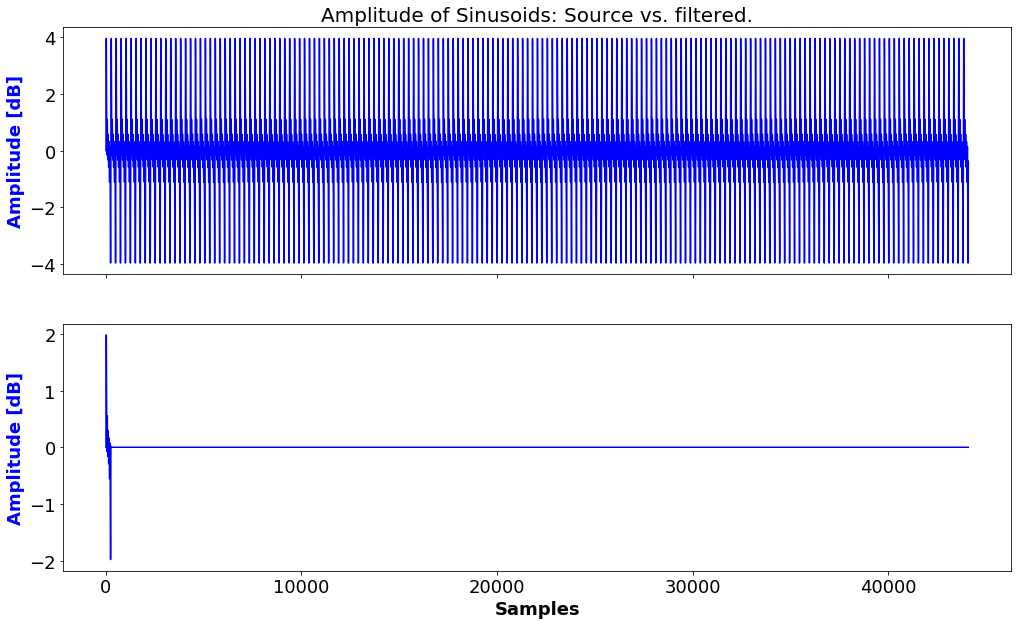

In [20]:
b, _, _, _ = fractional_delay(174)
sinusoid_harmonic_filtered = lfilter(b, [1], sinusoid_harmonic_ys)

f, axarr = plt.subplots(2, sharex=True, figsize=(17, 10))
# Plot magnitude
axarr[0].plot(sinusoid_harmonic_ys, 'blue')
axarr[0].set_ylabel('Amplitude [dB]', color='blue')
axarr[0].set_title('Amplitude of Sinusoids: Source vs. filtered.')
# Plot angles/phases
axarr[1].plot(sinusoid_harmonic_filtered, 'blue')
axarr[1].set_ylabel('Amplitude [dB]', color='blue')
plt.xlabel('Samples')

The filtered audio lost all the target harmonics.

(0, 2000)

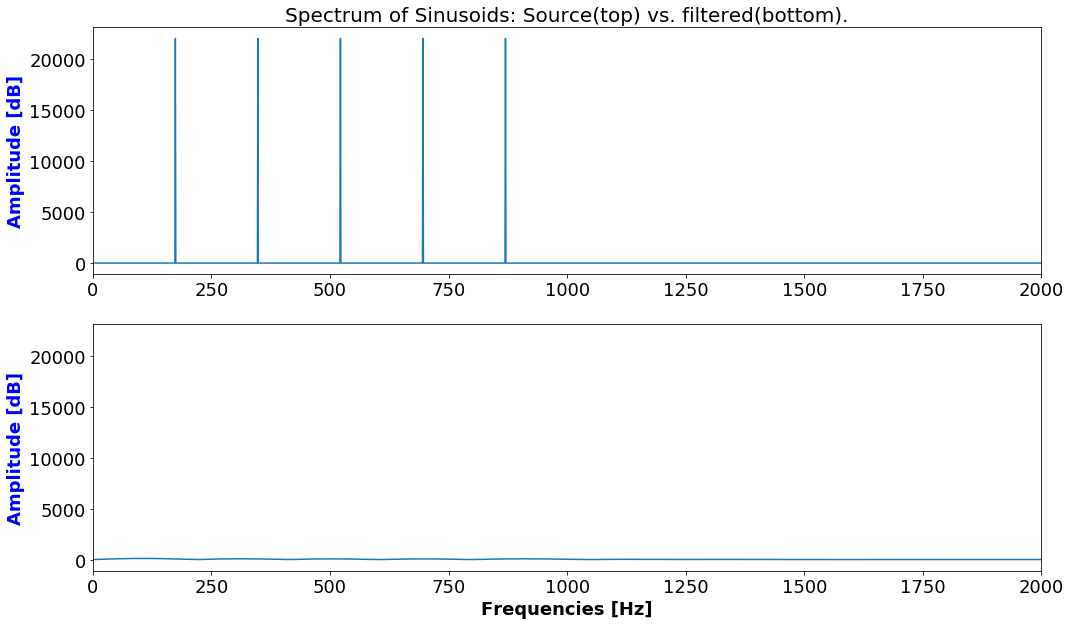

In [19]:
f, axarr = plt.subplots(2, sharey=True, figsize=(17, 10))
# Plot Source
fs, amps = make_spectrum(sinusoid_harmonic_ys)

axarr[0].plot(fs,amps)
axarr[0].set_ylabel('Amplitude [dB]', color='blue')
axarr[0].set_title('Spectrum of Sinusoids: Source(top) vs. filtered(bottom).')
axarr[0].set_xlim([0, 2000])
# Plot Filtered
fs, amps = make_spectrum(sinusoid_harmonic_filtered)
axarr[1].plot(fs, amps)
axarr[1].set_ylabel('Amplitude [dB]', color='blue')
plt.xlabel('Frequencies [Hz]')
axarr[1].set_xlim([0, 2000])

In [21]:
print("Sinusoid F2 harmonics")
display(sinusoid_harmonic_wav.make_audio())
b, _, _, _ = fractional_delay(174)
print("Sinusoid filtered")
display(Audio(sinusoid_harmonic_filtered, rate=44100))

Sinusoid F2 harmonics


Sinusoid filtered


## Apply filter to a clarinet sound – D2
Here we experiment our filter on more complex timbre, a clarinet recording. It removes the target harmonics, and only some noise is left.

In [9]:
_, clarinet = wavfile.read('data/d2.wav')
clarinet = clarinet[:,0]
print("Clarinet source")
display(Audio(clarinet, rate=44100) )

f0 = 146.832    # D2 in frequency
b, w, H, phases = fractional_delay(f0) 
print("Clarinet filtered")
clarinet_filtered = lfilter(b, [1], clarinet)
display(Audio(clarinet_filtered, rate=44100) )

Clarinet source


/Users/parks1/miniconda3/envs/asp/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Clarinet filtered


Text(0.5, 0, 'Samples')

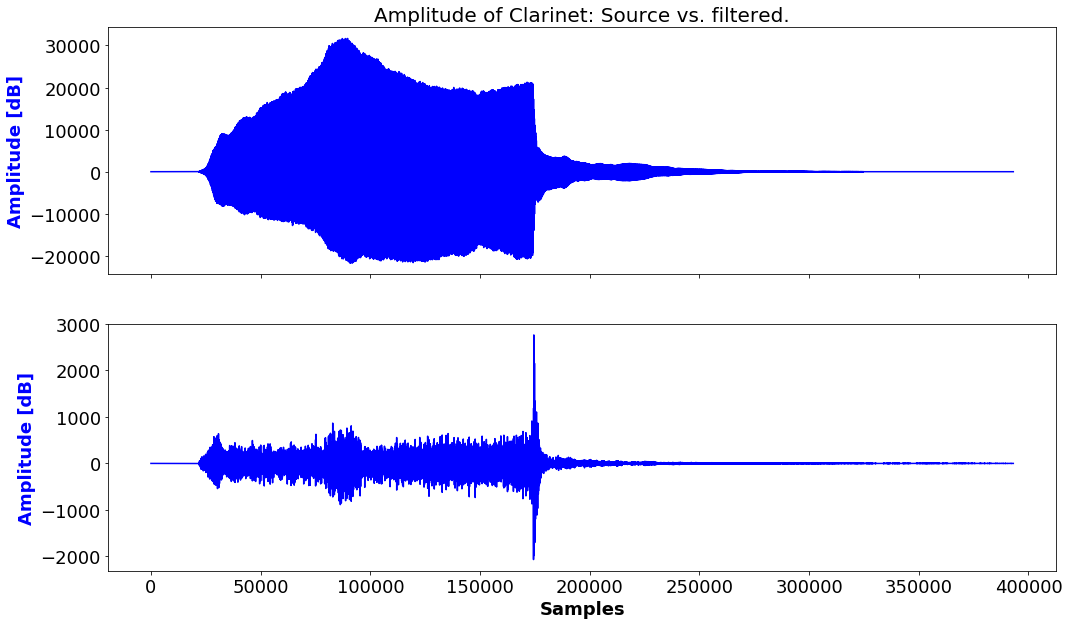

In [10]:
f, axarr = plt.subplots(2, sharex=True, figsize=(17, 10))
# Plot magnitude
axarr[0].plot(clarinet, 'blue')
axarr[0].set_ylabel('Amplitude [dB]', color='blue')
axarr[0].set_title('Amplitude of Clarinet: Source vs. filtered.')
# Plot angles/phases
axarr[1].plot(clarinet_filtered, 'blue')
axarr[1].set_ylabel('Amplitude [dB]', color='blue')
plt.xlabel('Samples')

(0, 2000)

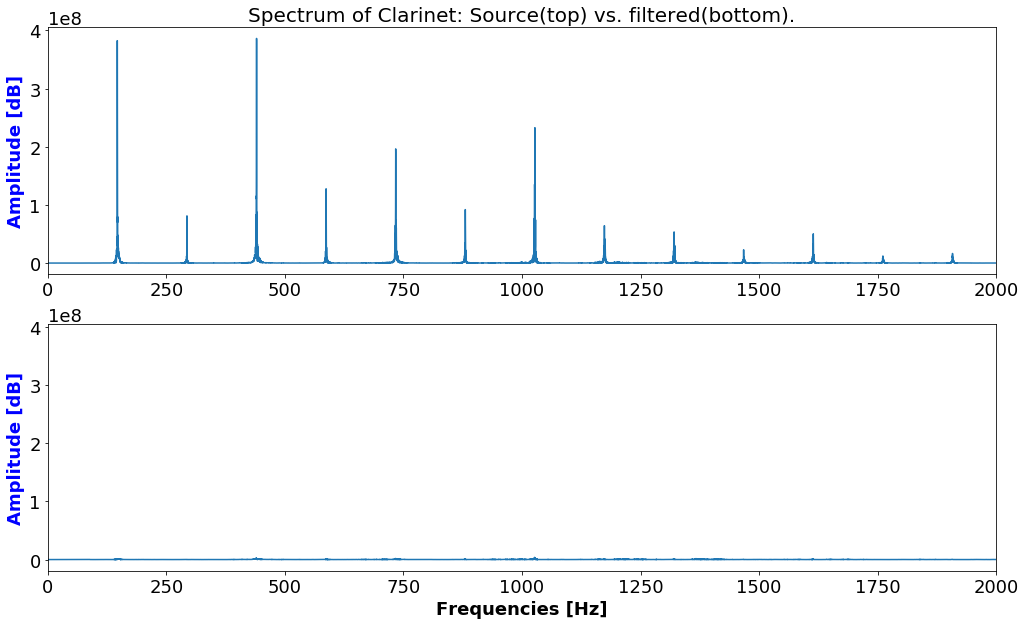

In [11]:
f, axarr = plt.subplots(2, sharey=True, figsize=(17, 10))
# Plot Source
fs, amps = make_spectrum(clarinet)

axarr[0].plot(fs,amps)
axarr[0].set_ylabel('Amplitude [dB]', color='blue')
axarr[0].set_title('Spectrum of Clarinet: Source(top) vs. filtered(bottom).')
axarr[0].set_xlim([0, 2000])
# Plot Filtered
fs, amps = make_spectrum(clarinet_filtered)
axarr[1].plot(fs, amps)
axarr[1].set_ylabel('Amplitude [dB]', color='blue')
plt.xlabel('Frequencies [Hz]')
axarr[1].set_xlim([0, 2000])

Text(0.5, 0, 'Time')

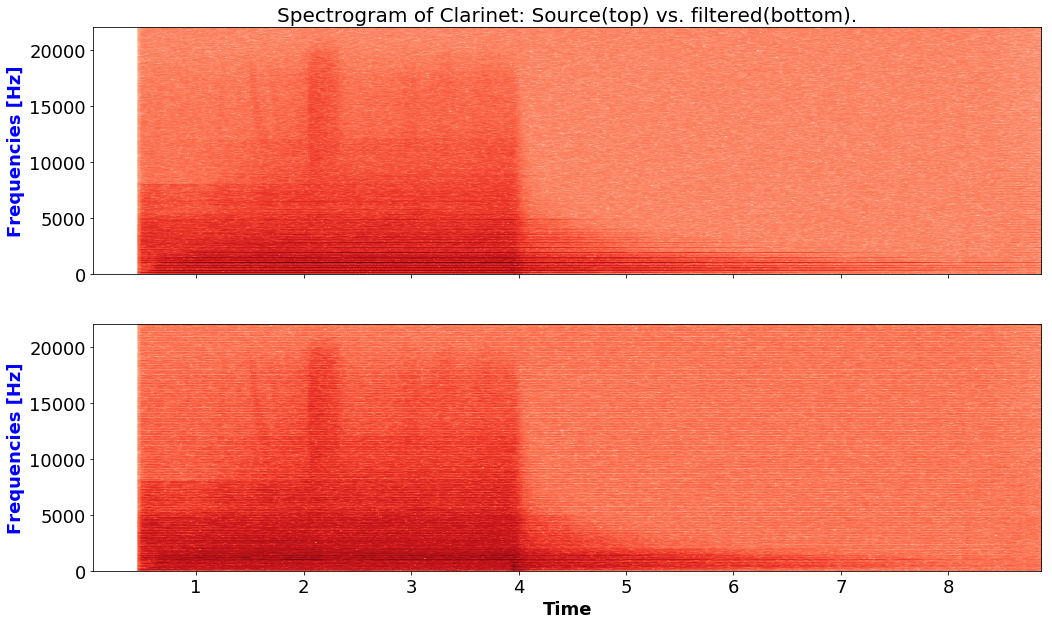

In [29]:
f, axarr = plt.subplots(2, sharex=True, sharey=True, figsize=(17, 10))
# Plot Source
axarr[0].specgram(clarinet, Fs=44100, NFFT=4096, noverlap=3500, cmap="Reds")
axarr[0].set_ylabel('Frequencies [Hz]', color='blue')
axarr[0].set_title('Spectrogram of Clarinet: Source(top) vs. filtered(bottom).')
# Plot Filtered
axarr[1].specgram(clarinet_filtered, Fs=44100, NFFT=4096, noverlap=3500, cmap="Reds")
axarr[1].set_ylabel('Frequencies [Hz]', color='blue')
plt.xlabel('Time')

## Apply filter to a clarinet sound – D2E2
Here we test on a clarinet recording of two keys: D2 and E2. The filtered recording sounds similar to the pure E2 recording.

In [26]:
_, clarinet = wavfile.read('data/d2e2.wav')
clarinet = clarinet[:,0]
print("Clarinet source: D2E2")
display(Audio(clarinet, rate=44100) )

f0 = 146.832    # D2 in frequency
b, w, H, phases = fractional_delay(f0) 
print("Clarinet D2 harmonics filtered")
clarinet_filtered = lfilter(b, [1], clarinet)
display(Audio(clarinet_filtered, rate=44100) )

_, clarinet_e2 = wavfile.read('data/e2.wav')
clarinet_e2 = clarinet_e2[:,0]
print("Clarinet Pure E2 ")
display(Audio(clarinet_e2, rate=44100) )



Clarinet source: D2E2


Clarinet D2 harmonics filtered


Clarinet Pure E2 


Text(0.5, 0, 'Samples')

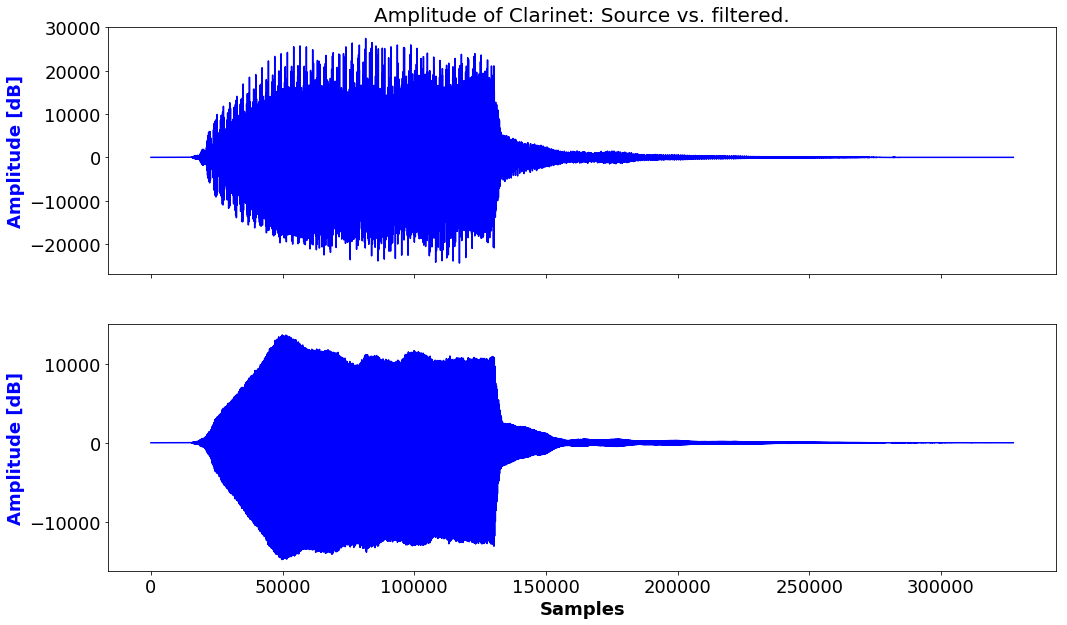

In [29]:
f, axarr = plt.subplots(2, sharex=True, figsize=(17, 10))
# Plot magnitude
axarr[0].plot(clarinet, 'blue')
axarr[0].set_ylabel('Amplitude [dB]', color='blue')
axarr[0].set_title('Amplitude of Clarinet: Source vs. filtered.')
# Plot angles/phases
axarr[1].plot(clarinet_filtered, 'blue')
axarr[1].set_ylabel('Amplitude [dB]', color='blue')

plt.xlabel('Samples')

(0, 2000)

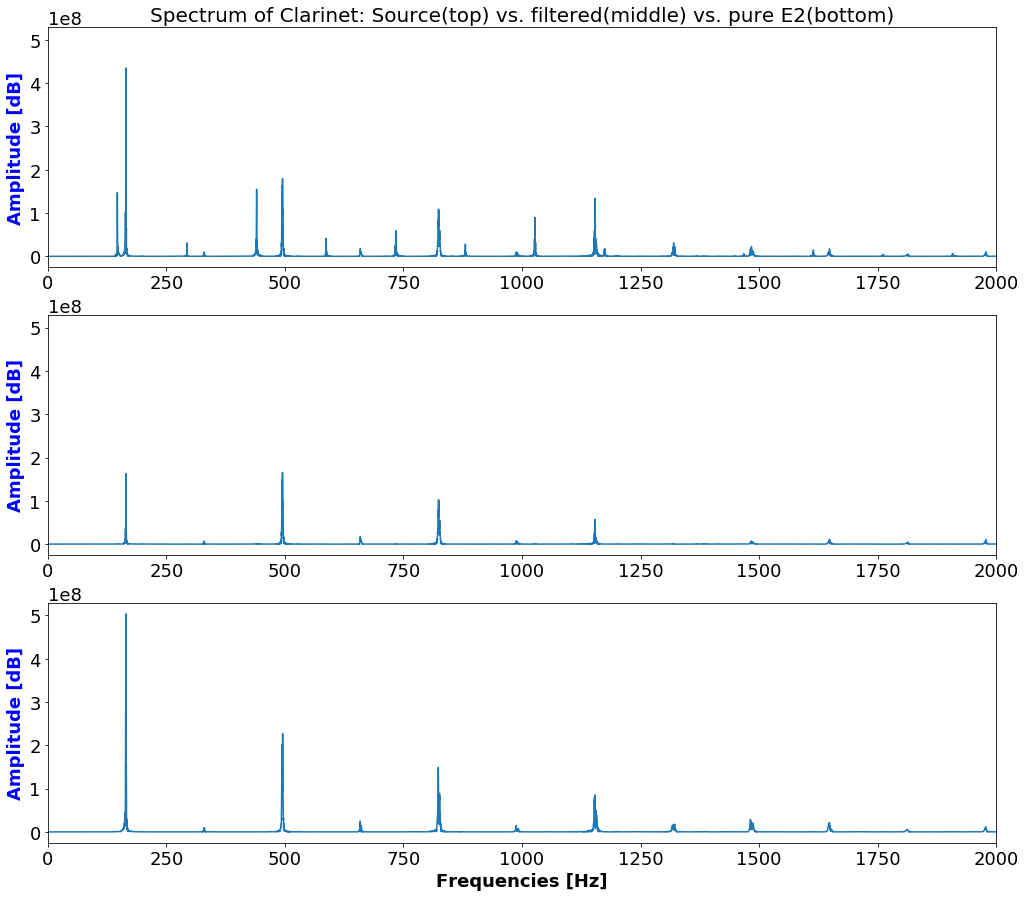

In [33]:
f, axarr = plt.subplots(3, sharey=True, figsize=(17, 15))
# Plot Source
fs, amps = make_spectrum(clarinet)

axarr[0].plot(fs,amps)
axarr[0].set_ylabel('Amplitude [dB]', color='blue')
axarr[0].set_title('Spectrum of Clarinet: Source(top) vs. filtered(middle) vs. pure E2(bottom)')
axarr[0].set_xlim([0, 2000])
# Plot Filtered
fs, amps = make_spectrum(clarinet_filtered)
axarr[1].plot(fs, amps)
axarr[1].set_ylabel('Amplitude [dB]', color='blue')
plt.xlabel('Frequencies [Hz]')
axarr[1].set_xlim([0, 2000])

fs, amps = make_spectrum(clarinet_e2)
axarr[2].plot(fs, amps)
axarr[2].set_ylabel('Amplitude [dB]', color='blue')
plt.xlabel('Frequencies [Hz]')
axarr[2].set_xlim([0, 2000])

Text(0.5, 0, 'Time')

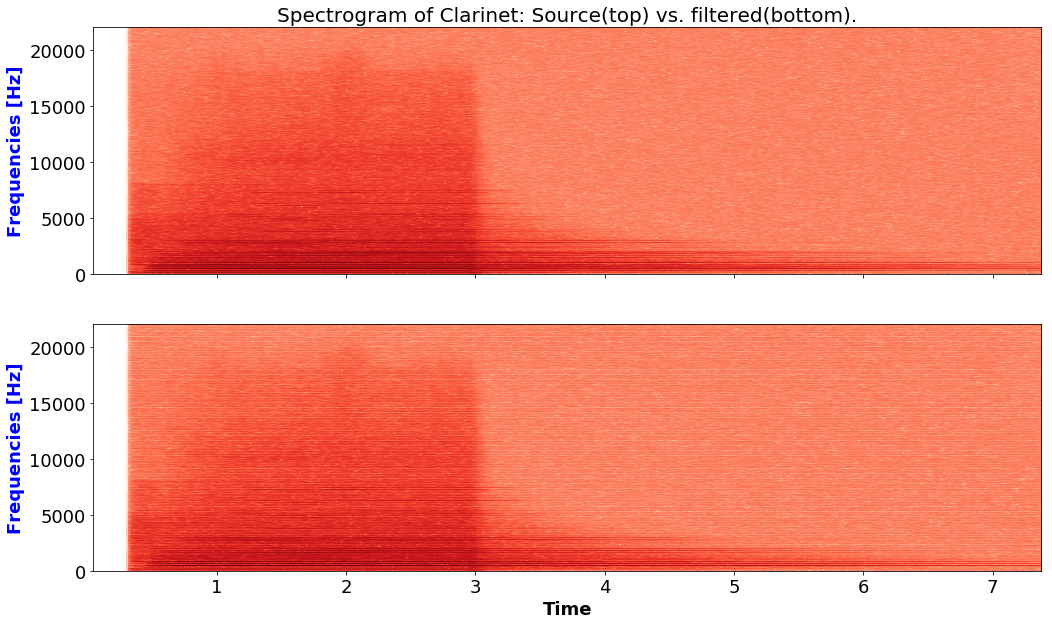

In [35]:
f, axarr = plt.subplots(2, sharex=True, sharey=True, figsize=(17, 10))
# Plot Source
axarr[0].specgram(clarinet, Fs=44100, NFFT=4096, noverlap=3500, cmap="Reds")
axarr[0].set_ylabel('Frequencies [Hz]', color='blue')
axarr[0].set_title('Spectrogram of Clarinet: Source(top) vs. filtered(bottom).')
# Plot Filtered
axarr[1].specgram(clarinet_filtered, Fs=44100, NFFT=4096, noverlap=3500, cmap="Reds")
axarr[1].set_ylabel('Frequencies [Hz]', color='blue')
plt.xlabel('Time')

## Conclusions
We implemented a fractional delay for harmonic removal. It removed sinusoid harmonics completely. Clarinet experiment shows the algorithm works on real instrument as well. For unknown reason, we were not able to implement the truncated version. 

## Acknowledgement
This work was completed with large help of Eero-Pekka Damskägg and Lauri Juvela at Aalto University Acoustics and Speech Labs.

## References
- *Canceling and selecting partials from musical tones using fractional-delay filters* by Lehtonen et al.